# Line Integrated Diagnostics

[LineIntegratedDiagnostic]: ../../api/plasmapy.diagnostics.path_integrated_diagnostic.LineIntegratedDiagnostic.rst#plasmapy.diagnostics.path_integrated_diagnostic.LineIntegratedDiagnostic

Many plasma diagnostics use a beam of light or particles to probe the properties of a plasma. Such measurements are inherently line-integrated: for example, an imaging interferometer reduces the density along the probe beam path, $n(x,y,z)$, to a 2D plane of phase shifts, $\Delta \phi(x,y)$. 

The [LineIntegratedDiagnostic] class in PlasmaPy provides an abstract framework for creating synthetic diagnostics that work in this manner. These synthetic diagnostics can then be used to predict the results of experimental measurements given an analytical model or simulation result describing a plasma. In this notebook, we will review the synthetic diagnostics implemented in PlasmaPy as subclasses of LineIntegrated Diagnostic. We will then explicitly re-create the `Interferometer` synthetic diagnostic class to provide an example of how the [LineIntegratedDiagnostic] abstract class can be subclassed to create a custom synthetic diagnostic.

In [1]:
import astropy.constants as const
import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np

from scipy.signal import medfilt

from plasmapy.diagnostics.path_integrated_diagnostic import (
    Interferometer,
    LineIntegratedDiagnostic,
)
from plasmapy.plasma.grids import CartesianGrid

## Contents

1. [The Line Integrated Diagnostic Framework](#The-Line-Integrated-Diagnostic-Framework)
1. [Interferometer](#Interferometer)
1. [Creating a Custom Diagnostic Class](#Creating-a-Custom-Diagnostic-Class)


## The Line Integrated Diagnostic Framework

[LineIntegratedDiagnostic]: ../../api/plasmapy.diagnostics.path_integrated_diagnostic.LineIntegratedDiagnostic.rst#plasmapy.diagnostics.path_integrated_diagnostic.LineIntegratedDiagnostic

[Grid]: ../../api/plasmapy.plasma.grids.rst#plasmapy.plasma.grids

<img src="line_integrated_diagnostic_setup.png">

A [LineIntegratedDiagnostic] class object is instantiated by providing a [Grid] object (representing the plasma to be measured) as well as vectors from the origin of the [Grid] to the detector plane and the source plane. The line integral through the grid is then calculated using the `line_integral` method. This method takes keywords that define the size and resolution of the detector. The line integral is then calculated using the following method:

1. A 2D array of points (Nx, Ny) in the detector plane is created. A corresponding array of points is created in the source plane. If the `collimated` keyword is False, all of the source points will instead be set equal to the point defined by the source vector. 
2. Equations are calculated for lines that connect each point in the detector plane to the corresponding point in the source plane. 
3. A number of points (set by the `num` keyword) are generated on each line in the region where the lines cross the grid. The result is a 3D array with dimensions (Nx, Ny, num).
4. The `integrand()` method is evaluated at each point in the 3D array.
5. The resulting integrand array is then integrated along the last dimension to produce the final (Nx,Ny) array representing the line-integral as collected in the detector plane.

Subclasses of [LineIntegratedDiagnostic] overwrite the `integrand()` method in order to line-integrate different quantities and thus represent different diagnostics.

## Interferometer

[Interferometer]: ../../api/plasmapy.diagnostics.path_integrated_diagnostic.interferometry.Interferometer.rst#plasmapy.diagnostics.path_integrated_diagnostic.interferometry.Interferometer

An interferometer diagnoses plasma density by measuring the phase shift ($\Delta \phi$) of a probe beam. The phase shift is 

\begin{equation}
\Delta \phi = -\frac{\omega_{probe}}{2 c n_c} \int n_e dl
\end{equation}

Where $\omega_{probe}$ is the probe beam frequency, $c$ is the speed of light, $\int n_e dl$ is the line-integrated electron density, and $n_c$ is the critical density

\begin{equation}
n_c = \frac{\epsilon_0 m_e}{e^2} \omega_{probe}^2
\end{equation}

The PlasmaPy [Interferometer] class calculates $\Delta \phi$ given a grid of electron densities. In order to demonstrate the use of this class, we will first create a cylinder of constant electron density.

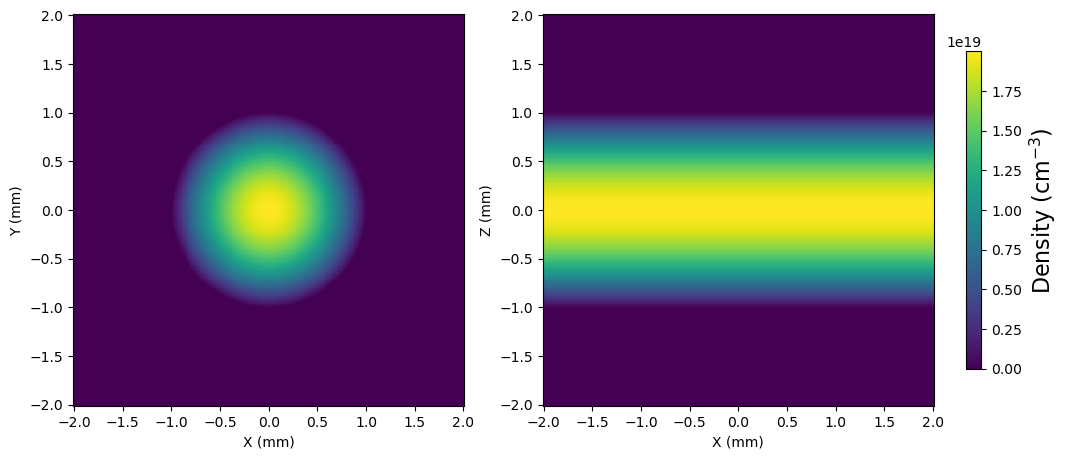

In [2]:
axis = np.linspace(-2, 2, num=200) * u.mm
xarr, yarr, zarr = np.meshgrid(axis, axis, axis, indexing="ij")
r = np.sqrt(xarr ** 2 + yarr ** 2)
r0 = 1 * u.mm
n_e = np.where(r < r0, np.cos((r / r0).value * np.pi / 2), 0) * 2e19 / u.cm ** 3
grid = CartesianGrid(xarr, yarr, zarr)
grid.add_quantities(n_e=n_e)


fig, ax = plt.subplots(ncols=2, figsize=(12, 6))
fig.subplots_adjust(right=1)
p1 = ax[0].pcolormesh(
    axis.to(u.mm).value, axis.to(u.mm).value, grid["n_e"][:, :, 100], shading="auto"
)
ax[0].set_xlabel("X (mm)")
ax[0].set_ylabel("Y (mm)")
ax[0].set_aspect("equal")

p2 = ax[1].pcolormesh(
    axis.to(u.mm).value, axis.to(u.mm).value, grid["n_e"][:, 100, :], shading="auto"
)
ax[1].set_xlabel("X (mm)")
ax[1].set_ylabel("Z (mm)")
ax[1].set_aspect("equal")

cb = fig.colorbar(p2, ax=ax, orientation="vertical", pad=0.03, shrink=0.7)
cb.ax.set_ylabel("Density (cm$^{-3}$)", fontsize=16);

Next we will instantiate an Interferometer object with this grid

In [3]:
source = (0 * u.mm, -5 * u.mm, 0 * u.mm)
detector = (0 * u.mm, 5 * u.mm, 0 * u.mm)
obj = Interferometer(grid, source, detector, verbose=False)

Finally, we will use the `evaluate` function to carry out the line integration and calculate the phase shift. This function takes the following arguments

- $\omega_{probe}$, the frequency of the probe beam in Hz
- `num` : The number of interpolated points over which the line integral is carried out.

and the keywords
- `size` : An array defining the size of the detector plane
- `bins` : A list of two values defining the horizontal and vertical resolution of the detector plane.
- `unwrapped` : If true, returns the total phase shift (without 2$\pi$ discontinuities).

In [4]:
wprobe = 1.14e15 * u.Hz
size = np.array([[-1, 1], [-1, 1]]) * 1.2 * u.mm
bins = [100, 100]
hax, vax, phase = obj.evaluate(wprobe, 30, size=size, bins=bins, unwrapped=False)
hax = hax.to(u.mm).value
vax = vax.to(u.mm).value

array([-1.2       , -1.17575758, -1.15151515, -1.12727273, -1.1030303 ,
       -1.07878788, -1.05454545, -1.03030303, -1.00606061, -0.98181818,
       -0.95757576, -0.93333333, -0.90909091, -0.88484848, -0.86060606,
       -0.83636364, -0.81212121, -0.78787879, -0.76363636, -0.73939394,
       -0.71515152, -0.69090909, -0.66666667, -0.64242424, -0.61818182,
       -0.59393939, -0.56969697, -0.54545455, -0.52121212, -0.4969697 ,
       -0.47272727, -0.44848485, -0.42424242, -0.4       , -0.37575758,
       -0.35151515, -0.32727273, -0.3030303 , -0.27878788, -0.25454545,
       -0.23030303, -0.20606061, -0.18181818, -0.15757576, -0.13333333,
       -0.10909091, -0.08484848, -0.06060606, -0.03636364, -0.01212121,
        0.01212121,  0.03636364,  0.06060606,  0.08484848,  0.10909091,
        0.13333333,  0.15757576,  0.18181818,  0.20606061,  0.23030303,
        0.25454545,  0.27878788,  0.3030303 ,  0.32727273,  0.35151515,
        0.37575758,  0.4       ,  0.42424242,  0.44848485,  0.47

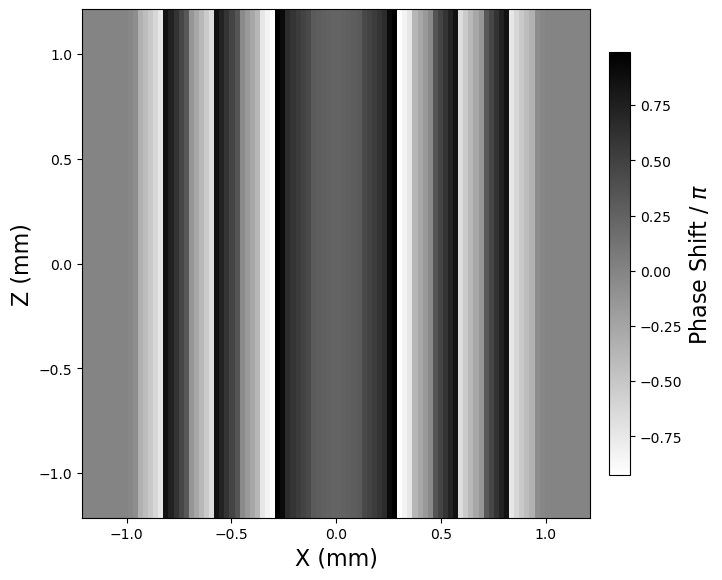

In [5]:
fig, ax = plt.subplots(figsize=(8, 8))
plot = ax.pcolormesh(hax, vax, phase.T / np.pi, cmap="binary", shading="auto")
ax.set_aspect("equal")
ax.set_xlabel("X (mm)", fontsize=16)
ax.set_ylabel("Z (mm)", fontsize=16)

cb = fig.colorbar(plot, ax=ax, orientation="vertical", pad=0.03, shrink=0.7)
cb.ax.set_ylabel("Phase Shift / $\pi$", fontsize=16);

The resulting image represents the line-integral through the 3D grid, projected onto the detector plane. Running the `evaluate` method with more `bins` and larger `num` will create a higher resolution image.

In [6]:
size = np.array([[-1, 1], [-1, 1]]) * 1.2 * u.mm
bins = [300, 300]
hax, vax, phase = obj.evaluate(wprobe, 400, size=size, bins=bins, unwrapped=False)
hax = hax.to(u.mm).value
vax = vax.to(u.mm).value

array([-1.2       , -1.19197324, -1.18394649, -1.17591973, -1.16789298,
       -1.15986622, -1.15183946, -1.14381271, -1.13578595, -1.1277592 ,
       -1.11973244, -1.11170569, -1.10367893, -1.09565217, -1.08762542,
       -1.07959866, -1.07157191, -1.06354515, -1.05551839, -1.04749164,
       -1.03946488, -1.03143813, -1.02341137, -1.01538462, -1.00735786,
       -0.9993311 , -0.99130435, -0.98327759, -0.97525084, -0.96722408,
       -0.95919732, -0.95117057, -0.94314381, -0.93511706, -0.9270903 ,
       -0.91906355, -0.91103679, -0.90301003, -0.89498328, -0.88695652,
       -0.87892977, -0.87090301, -0.86287625, -0.8548495 , -0.84682274,
       -0.83879599, -0.83076923, -0.82274247, -0.81471572, -0.80668896,
       -0.79866221, -0.79063545, -0.7826087 , -0.77458194, -0.76655518,
       -0.75852843, -0.75050167, -0.74247492, -0.73444816, -0.7264214 ,
       -0.71839465, -0.71036789, -0.70234114, -0.69431438, -0.68628763,
       -0.67826087, -0.67023411, -0.66220736, -0.6541806 , -0.64

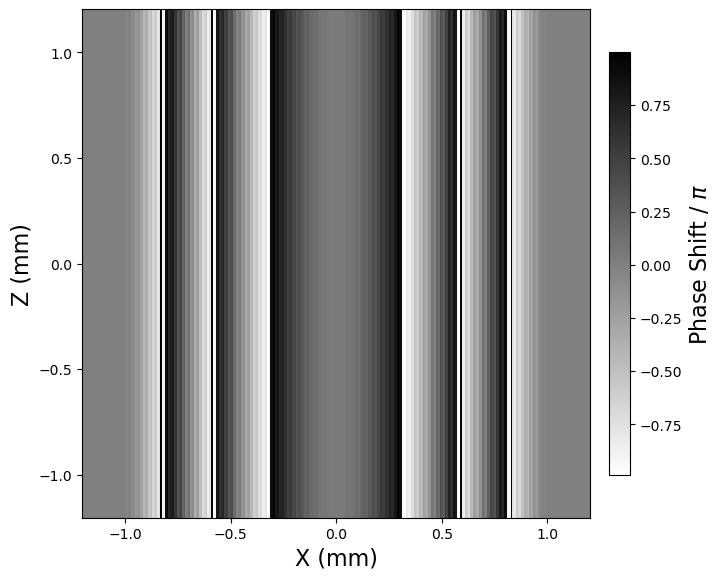

In [7]:
fig, ax = plt.subplots(figsize=(8, 8))
plot = ax.pcolormesh(hax, vax, phase.T / np.pi, cmap="binary", shading="auto")
ax.set_aspect("equal")
ax.set_xlabel("X (mm)", fontsize=16)
ax.set_ylabel("Z (mm)", fontsize=16)

cb = fig.colorbar(plot, ax=ax, orientation="vertical", pad=0.03, shrink=0.7)
cb.ax.set_ylabel("Phase Shift / $\pi$", fontsize=16);

[scipy.signal.medfilt]: https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.medfilt.html

The alternating fringes in the image are phase jumps which occur when the phase shift exceeds $2 \pi$. With an experimental interferogram, these phase jumps must be 'unwrapped' to recover the total phase shift, which is possible when a region of zero phase shift is present in the image. In this case, $\Delta \phi = 0$ along the horizontal boundaries of the image, so each row of the interferogram can be unwrapped separately.

Since this method is sensitive to the finite resolution noise on the interferogram, we will first average over the vertical dimension and apply a median filter ([scipy.signal.medfilt]) to smooth the profile.

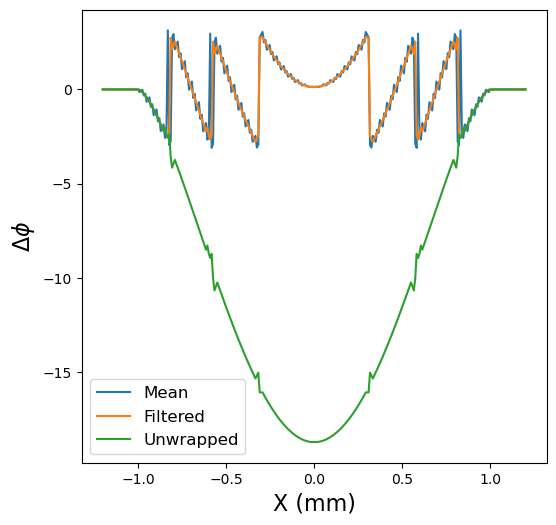

In [8]:
mean_phase = np.mean(phase, axis=1)
filt_phase = medfilt(mean_phase, 5)
unwrapped = np.unwrap(filt_phase)

fig, ax = plt.subplots(figsize=(6, 6))
ax.plot(hax, mean_phase, label="Mean")
ax.plot(hax, filt_phase, label="Filtered")
ax.plot(hax, unwrapped, label="Unwrapped")
ax.legend(fontsize=12)
ax.set_xlabel("X (mm)", fontsize=16)
ax.set_ylabel("$\Delta \phi$", fontsize=16);

The line-integrated density can then be recovered from the unwrapped phase

\begin{equation}
\int n_e dl = \frac{2 c \epsilon_0 m_e}{e^2} \omega_p \Delta \phi
\end{equation}

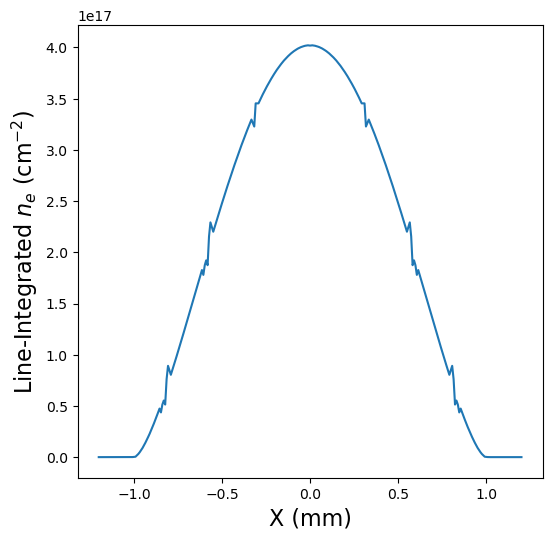

In [9]:
int_ne = (
    -2 * const.c * const.eps0.si * const.m_e / const.e.si ** 2 * wprobe * unwrapped
).to(u.cm ** -2)

fig, ax = plt.subplots(figsize=(6, 6))
ax.plot(hax, int_ne.value)
ax.set_xlabel("X (mm)", fontsize=16)
ax.set_ylabel("Line-Integrated $n_e$ (cm$^{-2}$)", fontsize=16);

The unwrapped phase shift can also be recovered directly from the `Interferometer` class by running `evaluate` with `unwrapped = True`.

In [10]:
size = np.array([[-1, 1], [-1, 1]]) * 1.2 * u.mm
bins = [300, 300]
hax, vax, phase = obj.evaluate(wprobe, 400, size=size, bins=bins, unwrapped=True)
hax = hax.to(u.mm).value
vax = vax.to(u.mm).value

array([-1.2       , -1.19197324, -1.18394649, -1.17591973, -1.16789298,
       -1.15986622, -1.15183946, -1.14381271, -1.13578595, -1.1277592 ,
       -1.11973244, -1.11170569, -1.10367893, -1.09565217, -1.08762542,
       -1.07959866, -1.07157191, -1.06354515, -1.05551839, -1.04749164,
       -1.03946488, -1.03143813, -1.02341137, -1.01538462, -1.00735786,
       -0.9993311 , -0.99130435, -0.98327759, -0.97525084, -0.96722408,
       -0.95919732, -0.95117057, -0.94314381, -0.93511706, -0.9270903 ,
       -0.91906355, -0.91103679, -0.90301003, -0.89498328, -0.88695652,
       -0.87892977, -0.87090301, -0.86287625, -0.8548495 , -0.84682274,
       -0.83879599, -0.83076923, -0.82274247, -0.81471572, -0.80668896,
       -0.79866221, -0.79063545, -0.7826087 , -0.77458194, -0.76655518,
       -0.75852843, -0.75050167, -0.74247492, -0.73444816, -0.7264214 ,
       -0.71839465, -0.71036789, -0.70234114, -0.69431438, -0.68628763,
       -0.67826087, -0.67023411, -0.66220736, -0.6541806 , -0.64

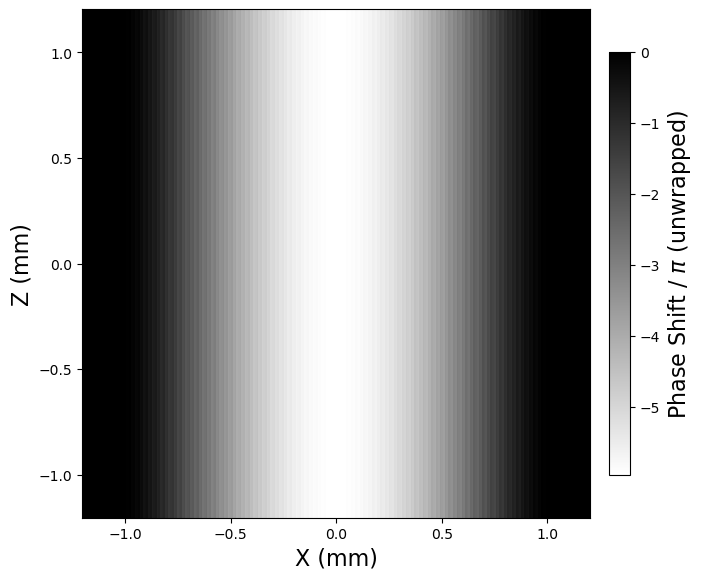

In [11]:
fig, ax = plt.subplots(figsize=(8, 8))
plot = ax.pcolormesh(hax, vax, phase.T / np.pi, cmap="binary", shading="auto")
ax.set_aspect("equal")
ax.set_xlabel("X (mm)", fontsize=16)
ax.set_ylabel("Z (mm)", fontsize=16)

cb = fig.colorbar(plot, ax=ax, orientation="vertical", pad=0.03, shrink=0.7)
cb.ax.set_ylabel("Phase Shift / $\pi$ (unwrapped)", fontsize=16);

As with any LineIntegratedDiagnostic, `Interferometer` is capable of line-integrating through grids at arbitrary angles as set by the provided source and detector vectors. The following example integrates through the test cylinder at an angle of $45^\circ$ to the cylinder axis.

In [12]:
source = (0 * u.mm, -5 * u.mm, -5 * u.mm)
detector = (0 * u.mm, 5 * u.mm, 5 * u.mm)
obj = Interferometer(grid, source, detector, verbose=False)

size = np.array([[-1, 1], [-1, 1]]) * 1.5 * u.mm
bins = [300, 300]
hax, vax, phase = obj.evaluate(wprobe, 400, size=size, bins=bins, unwrapped=False)
hax = hax.to(u.mm).value
vax = vax.to(u.mm).value

array([-1.5       , -1.48996656, -1.47993311, -1.46989967, -1.45986622,
       -1.44983278, -1.43979933, -1.42976589, -1.41973244, -1.409699  ,
       -1.39966555, -1.38963211, -1.37959866, -1.36956522, -1.35953177,
       -1.34949833, -1.33946488, -1.32943144, -1.31939799, -1.30936455,
       -1.2993311 , -1.28929766, -1.27926421, -1.26923077, -1.25919732,
       -1.24916388, -1.23913043, -1.22909699, -1.21906355, -1.2090301 ,
       -1.19899666, -1.18896321, -1.17892977, -1.16889632, -1.15886288,
       -1.14882943, -1.13879599, -1.12876254, -1.1187291 , -1.10869565,
       -1.09866221, -1.08862876, -1.07859532, -1.06856187, -1.05852843,
       -1.04849498, -1.03846154, -1.02842809, -1.01839465, -1.0083612 ,
       -0.99832776, -0.98829431, -0.97826087, -0.96822742, -0.95819398,
       -0.94816054, -0.93812709, -0.92809365, -0.9180602 , -0.90802676,
       -0.89799331, -0.88795987, -0.87792642, -0.86789298, -0.85785953,
       -0.84782609, -0.83779264, -0.8277592 , -0.81772575, -0.80

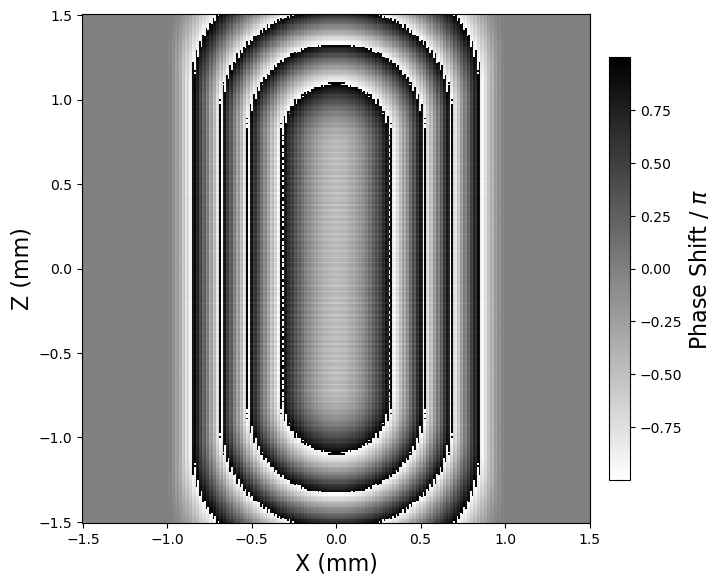

In [13]:
fig, ax = plt.subplots(figsize=(8, 8))
plot = ax.pcolormesh(hax, vax, phase.T / np.pi, cmap="binary", shading="auto")
ax.set_aspect("equal")
ax.set_xlabel("X (mm)", fontsize=16)
ax.set_ylabel("Z (mm)", fontsize=16)

cb = fig.colorbar(plot, ax=ax, orientation="vertical", pad=0.03, shrink=0.7)
cb.ax.set_ylabel("Phase Shift / $\pi$", fontsize=16);

## Creating a Custom Diagnostic Class

[LineIntegratedDiagnostic]: ../../api/plasmapy.diagnostics.path_integrated_diagnostic.LineIntegratedDiagnostic.rst#plasmapy.diagnostics.path_integrated_diagnostic.LineIntegratedDiagnostic

A [LineIntegratedDiagnostic] synthetic diagnostic for interferometry ([Interferometer]) is already implemented in PlasmaPy. However, in this notebook we will re-create this class in order to demonstrate how a custom subclass of [LineIntegratedDiagnostic] can be used to create a new synthetic diagnostic.

In order to predict the phase shift through a plasma, we therefore only need to know the density line-integrated along the probe beam axis. This can be accomplished by defining a [LineIntegratedDiagnostic] with an appropriate `_integrand()` method as follows.

In [14]:
class ExampleInterferometer(LineIntegratedDiagnostic):
    def _integrand(self, pts):
        # Reshape the pts array from grid shape (nx, ny, nz, 3) to a list
        # of points (nx*ny*nz, 3) as required by the grids interpolators
        nx, ny, nz, ndim = pts.shape
        pts = np.reshape(pts, (nx * ny * nz, ndim))

        integrand = self.grid.volume_averaged_interpolator(pts, "n_e")

        # Reshape the integrands from (nx*ny*nz) to (nx, ny, nz)
        integrand = np.reshape(integrand, (nx, ny, nz))

        return integrand

    def evaluate(
        self,
        probe_freq: u.Hz,
        num,
        size=np.array([[-1, 1], [-1, 1]]) * u.cm,
        bins=[50, 50],
        collimated=True,
        unwrapped=False,
    ):

        n_c = (
            (const.eps0.si * const.m_e / const.e.si ** 2)
            * (2 * np.pi) ** 2
            * probe_freq ** 2
        ).to(u.cm ** -3)

        hax, vax, int_ne = self._line_integral(
            size=size, bins=bins, collimated=collimated, num=num
        )

        phase_shift = (-np.pi * probe_freq / (const.c.si * n_c)) * int_ne
        phase_shift = phase_shift.to(u.dimensionless_unscaled).value

        if not unwrapped:
            phase_shift = (phase_shift + np.pi) % (2 * np.pi) - np.pi

        return hax, vax, phase_shift

[LineIntegratedDiagnostic]: ../../api/plasmapy.diagnostics.path_integrated_diagnostic.LineIntegratedDiagnostic.rst#plasmapy.diagnostics.path_integrated_diagnostic.LineIntegratedDiagnostic

In this case, the `_integrand()` method will return the density at each of the integration points. The `evaluate()` method is a wrapper around the `_line_integral()` method of [LineIntegratedDiagnostic] that calculates the total phase shift from the line-integrated density. If the `unwrapped` keyword is not set, then the function takes the modulus with respect to $2 \pi$ to estimate where jumps in the phase will occur.

In order to demonstrate the use of this ExampleInterferometer class, we will create an interferogram from an example grid which contains a sphere of constant density.

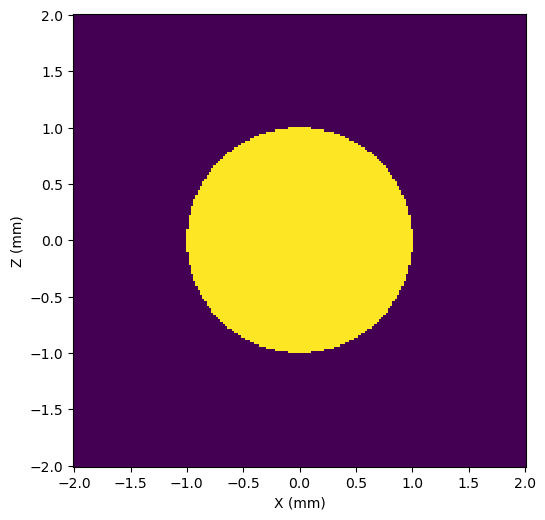

In [15]:
axis = np.linspace(-2, 2, num=200) * u.mm
xarr, yarr, zarr = np.meshgrid(axis, axis, axis, indexing="ij")
r = np.sqrt(xarr ** 2 + yarr ** 2 + zarr ** 2)
n_e = np.where(r < 1 * u.mm, 1, 0) * 3e19 / u.cm ** 3
grid = CartesianGrid(xarr, yarr, zarr)
grid.add_quantities(n_e=n_e)

fig, ax = plt.subplots(figsize=(6, 6))
ax.pcolormesh(
    axis.to(u.mm).value, axis.to(u.mm).value, grid["n_e"][:, 100, :], shading="auto"
)
ax.set_xlabel("X (mm)")
ax.set_ylabel("Z (mm)")
ax.set_aspect("equal")

Now we can initialize the `ExampleInterferometer` class by also defining the locations of the source and detector

In [16]:
source = (0 * u.mm, -5 * u.mm, 0 * u.mm)
detector = (0 * u.mm, 5 * u.mm, 0 * u.mm)
obj = Interferometer(grid, source, detector, verbose=False)

Finally we will specify the size and resolution of the detector plane when calling the `evaluate()` method to create the synthetic interferogram.

In [17]:
size = np.array([[-1, 1], [-1, 1]]) * 1.2 * u.mm
bins = [300, 300]

hax, vax, phase = obj.evaluate(1.14e15 * u.Hz, 400, size=size, bins=bins)
hax = hax.to(u.mm).value
vax = vax.to(u.mm).value

array([-1.2       , -1.19197324, -1.18394649, -1.17591973, -1.16789298,
       -1.15986622, -1.15183946, -1.14381271, -1.13578595, -1.1277592 ,
       -1.11973244, -1.11170569, -1.10367893, -1.09565217, -1.08762542,
       -1.07959866, -1.07157191, -1.06354515, -1.05551839, -1.04749164,
       -1.03946488, -1.03143813, -1.02341137, -1.01538462, -1.00735786,
       -0.9993311 , -0.99130435, -0.98327759, -0.97525084, -0.96722408,
       -0.95919732, -0.95117057, -0.94314381, -0.93511706, -0.9270903 ,
       -0.91906355, -0.91103679, -0.90301003, -0.89498328, -0.88695652,
       -0.87892977, -0.87090301, -0.86287625, -0.8548495 , -0.84682274,
       -0.83879599, -0.83076923, -0.82274247, -0.81471572, -0.80668896,
       -0.79866221, -0.79063545, -0.7826087 , -0.77458194, -0.76655518,
       -0.75852843, -0.75050167, -0.74247492, -0.73444816, -0.7264214 ,
       -0.71839465, -0.71036789, -0.70234114, -0.69431438, -0.68628763,
       -0.67826087, -0.67023411, -0.66220736, -0.6541806 , -0.64

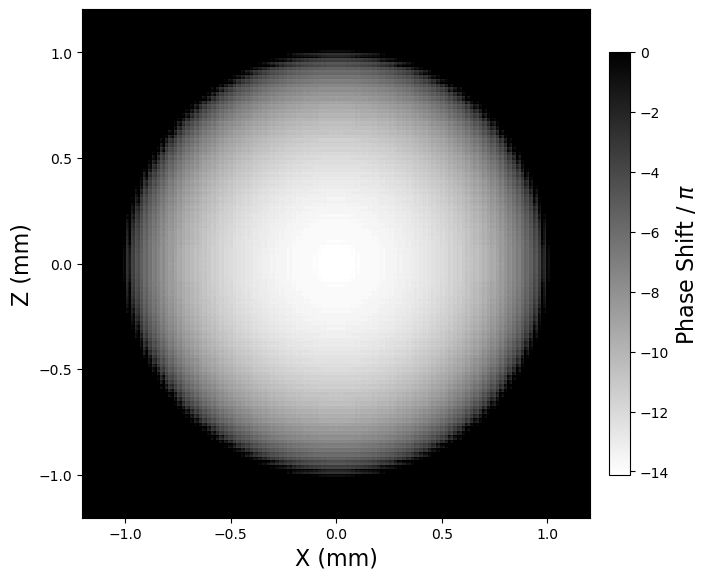

In [18]:
fig, ax = plt.subplots(figsize=(8, 8))
plot = ax.pcolormesh(hax, vax, phase.T / np.pi, cmap="binary", shading="auto")
ax.set_aspect("equal")
ax.set_xlabel("X (mm)", fontsize=16)
ax.set_ylabel("Z (mm)", fontsize=16)

cb = fig.colorbar(plot, ax=ax, orientation="vertical", pad=0.03, shrink=0.7)
cb.ax.set_ylabel("Phase Shift / $\pi$", fontsize=16);